In [1]:
import scanpy as sc
import pandas as pd # for handling data frames (i.e. data tables)
import numpy as np # for handling numbers, arrays, and matrices
import matplotlib.pyplot as plt # plotting package
import seaborn as sns # plotting package

**Exercise 0**: Before we continue in this notebook with the next steps of the analysis, we need to load our results from the previous notebook using the `sc.read_h5ad` function and assign them to the variable name `adata`. Give it a try!

In [2]:
adata = sc.read_h5ad("PBMC_analysis_SIB_tutorial2.h5ad")

## Principal component analysis

Dimensionality reduction methods seek to take a large set of variables and return a smaller set of components that still contain most of the information in the original dataset. One of the simplest forms of dimensionality reduction is PCA. Principal component analysis (PCA) is a mathematical procedure that transforms a number of possibly correlated (e.g., expression of genes in a network) variables into a (smaller) number of uncorrelated variables called principal components ("PCs").

**Exercise 1**: Run PCA analysis using `sc.pp.pca` in scanpy. Plot a scatter plot of the first principal components and try to identify how many components are needed to explain 50% of the variance in the data.

In [3]:
sc.pp.pca(adata, svd_solver="arpack", n_comps=100)

We can then visualize the first two components of the PCA as a scatter plot using `ss.pl.pca`. The first two components capture the largest axes of variability in the data.

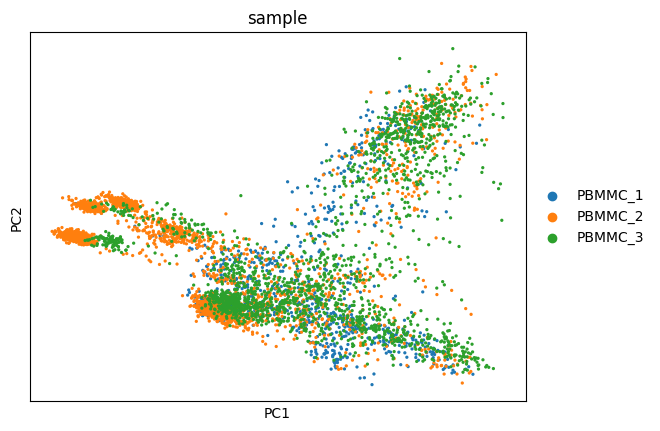

In [4]:
sc.pl.pca_scatter(adata, color="sample")

**Exercise 2:** We can color the PCA plot according to any factor that is present in `adata.obs`, or for any gene's expression. Can you `color` by the column `n_counts` and `phase`? What about by the genes `HBA1` (an alpha subunit of hemoglobin) `IGKC` (one of the most highly variable genes)?

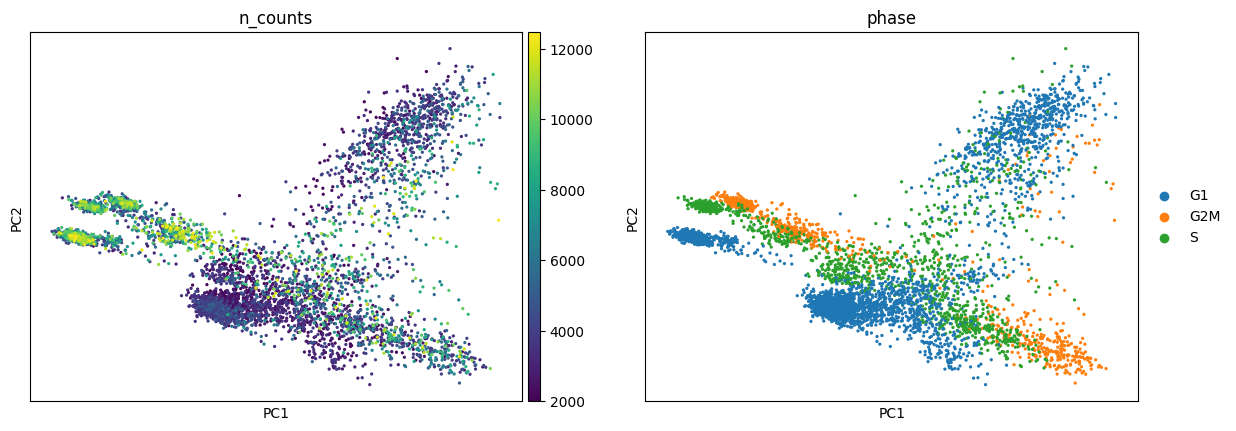

In [5]:
# visualize the first PCs, color by cell cycle phase and n_counts (unnormalized)
sc.pl.pca_scatter(adata, color=["n_counts", "phase"])

Each principal component scores the contribution of each gene to that component. Therefore, we can see which genes are more highly correlated to one component compared to the others. 

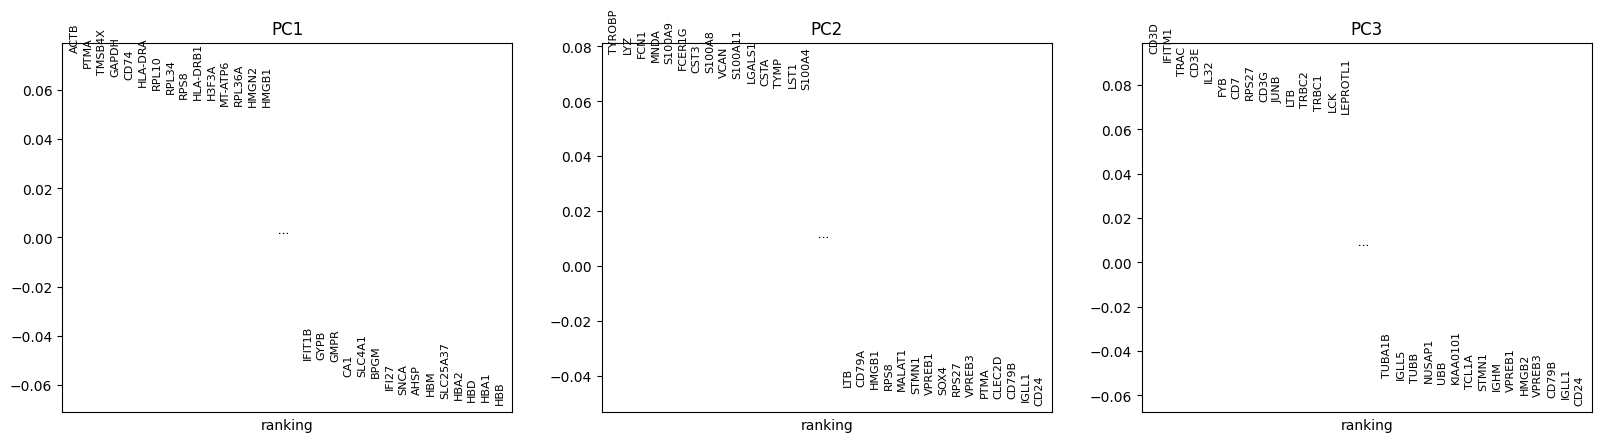

In [6]:
sc.pl.pca_loadings(adata, components = '1,2,3')

Since PCA is a geometric form of dimensionality reduction, we can visualize the specific genes that most strongly contribute to each principal component. This allows us to get an idea of which components discriminate which cells from each other.

In [7]:
def pca_heatmap(adata, component, groupby, use_raw=False, layer=None):
    attr = 'varm'
    keys = 'PCs'
    scores = getattr(adata, attr)[keys][:, component]
    dd = pd.DataFrame(scores, index=adata.var_names)
    var_names_pos = dd.sort_values(0, ascending=False).index[:20]

    var_names_neg = dd.sort_values(0, ascending=True).index[:20]

    pd2 = pd.DataFrame(adata.obsm['X_pca'][:, component], index=adata.obs.index)

    bottom_cells = pd2.sort_values(0).index[:300].tolist()
    top_cells = pd2.sort_values(0, ascending=False).index[:300].tolist()

    sc.pl.heatmap(adata[top_cells+bottom_cells], list(var_names_pos) + list(var_names_neg), 
                        show_gene_labels=False, groupby=groupby,
                        swap_axes=True, cmap='viridis', 
                        use_raw=use_raw, layer=layer, figsize=(6,4))

**Exercise 3:** Use the `pca_heatmap` function defined above to plot the 0th and 1st components. Group the top/bottom cells by their `sample` identifier?

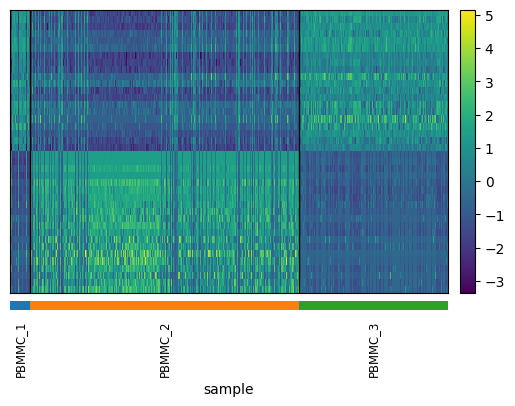

In [8]:
pca_heatmap(adata, component=0, groupby="sample")

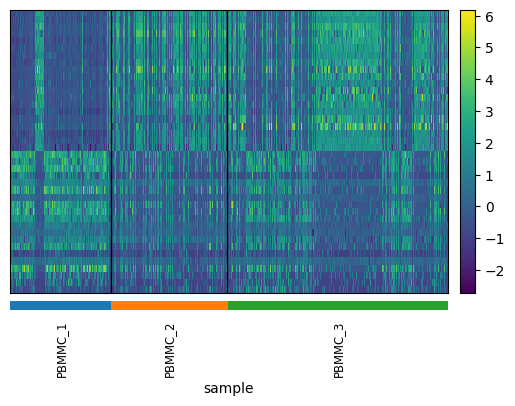

In [9]:
pca_heatmap(adata, component=1, groupby="sample")

**Exercise 4:** Do you see anything strange about these results? Is there something undesirable about the way in which the PCs discriminate cell populations that might not be biological?

For further dimensionality reduction, we need to select a number of PCs to use (the rest are excluded). Ideally, we want to capture as much data variance as possible in as few PCs as possible. The plot generated with `pca_variance_ratio` can help you in determining how many PCs to use for downstream analysis such as UMAP:

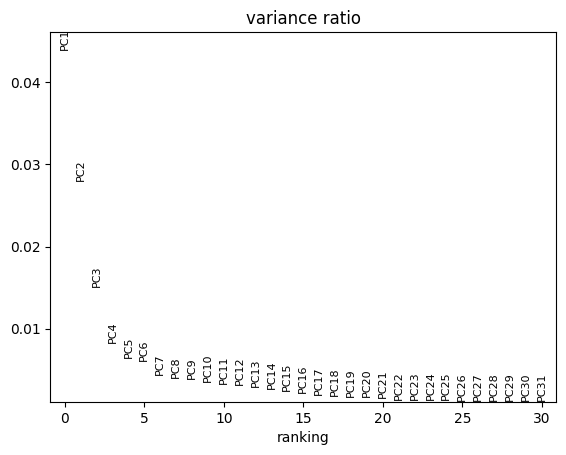

In [10]:
sc.pl.pca_variance_ratio(adata, log=False) # see contribution of each PC to variance

This plot ranks principle components based on the percentage of variance explained by each one. Where we observe an “elbow” or flattening curve, the majority of true signal is captured by this number of PCs, eg around 20 PCs for the `adata` dataset.

Including too many PCs usually does not affect much the result, while including too few PCs can affect the results very much

Another - maybe more intuitive - way to see it, is to use a cumulative sum to show the % unexplained variance in function of the number of PCs. If we look at the first PCs, we can see that we passed the elbow with 30 to 50 PCs, which should ensure that we capture the major part of the variability in our dataset to be shown on a 2D representation like UMAP or tSNE.

Text(0.5, 0, 'N PCs')

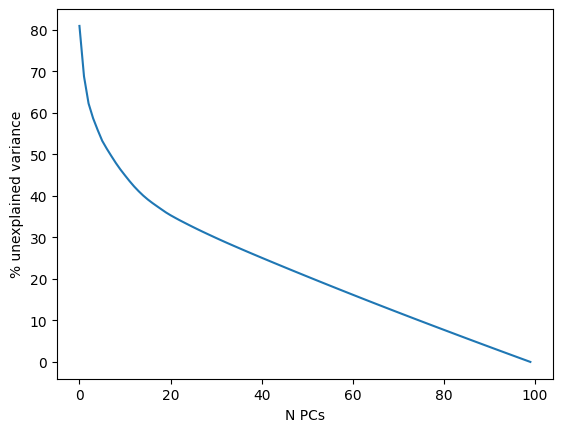

In [11]:
plt.plot(100 - (np.cumsum(adata.uns["pca"]["variance_ratio"])*100)/sum(adata.uns["pca"]["variance_ratio"]))
plt.ylabel('% unexplained variance') ; plt.xlabel('N PCs')

## Dimensionality reduction

**Exercise 5:** Compute the neighborhood graph of cells using the PCA representation of the data matrix. The purpose of this step is to understand the “distance” between individual cells in the lower-dimensional PCA space, important for creating 2D scatter plot representations of your data. The number of neighbors used will influence how much the data is smoothened, which is a necessary step due to the sparsity (missing values) widely present in scRNA-seq data compared to bulk methods.

In [12]:
sc.pp.neighbors(adata, n_pcs = 30) # specify the number of neighbors and number of PCs you wish to use

/home/alex/anaconda3/envs/sib_course_2024/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Embedding the graph in a 2D representation can be performed using either tSNE or UMAP algorithms.

**Exercise 6**: Run UMAP algorithm on your data after completing the previous steps with default parameters. We will evaluate the quality of each approach in later exercises.

In [13]:
sc.tl.umap(adata)

To view the UMAP plot: 

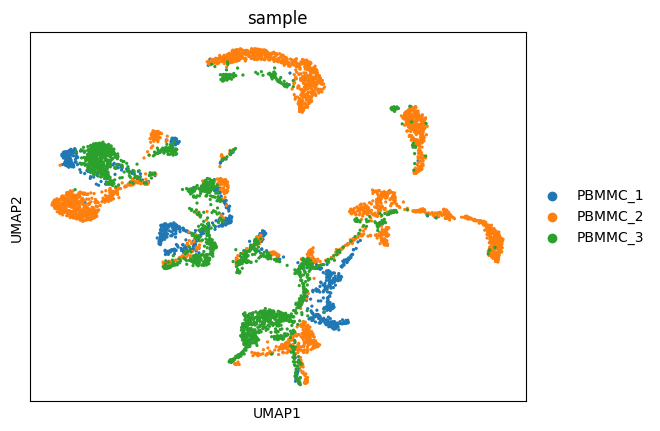

In [14]:
sc.pl.umap(adata, color=["sample"])

**Exercise 7**: Try to change:

A. Color the dots in the UMAP according to a variable (e.g. `n_counts` or `HBA1`). Any idea where the erythrocytes probably are in the UMAP?

B. The number of neighbors used for the calculation of the UMAP. Which is the parameter to change and how did it affect the output. What is the default? In which situation would you lower/increase this?

C. The number of principal components (n_pcs) to extremely few (5) or many (50). How does this it affect the output? In your opinion, it is better with fewer or more PCs? Why does n_pcs=150 not work? When would more precision be needed?

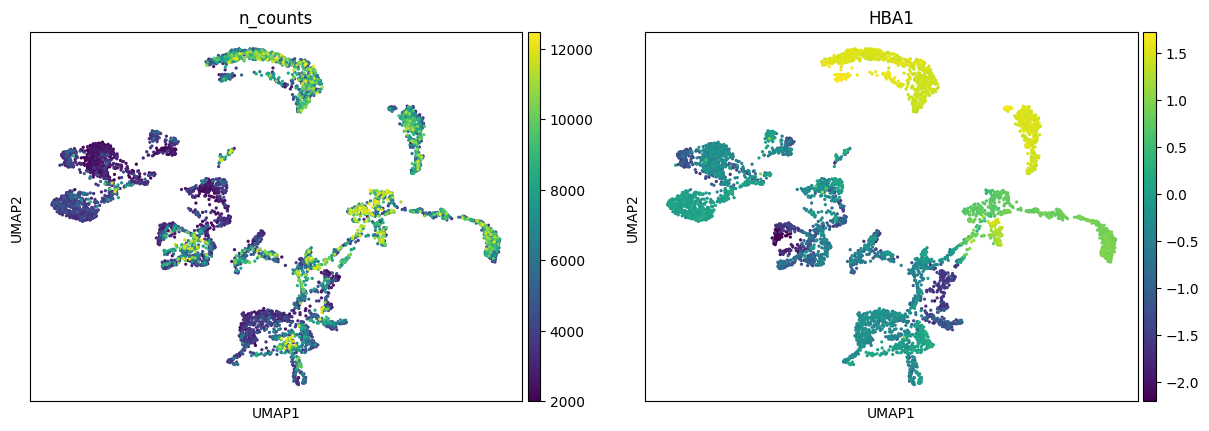

In [15]:
sc.pl.umap(adata, color=["n_counts", "HBA1"])

Save your results!

In [16]:
adata.write_h5ad("PBMC_analysis_SIB_tutorial3.h5ad")